# Hyper-Parameter Tuning

> NOTE: a unigram model is the current considered option

On using Latent Dirichlet Allocation `LDA`, the most important hyperparameters are:

- **k**: The number of topics.
- **&alpha;**: the Dirichlet prior for document/topic distribution.
- **&eta;**: the Dirichlet prior for topic/word distribution.

[Gensim](https://radimrehurek.com/gensim/index.html)'s implementation of `LDA` will be used.
Specifically the multi-cored variant [LdaMulticore](https://radimrehurek.com/gensim/models/ldamulticore.html)

These resources were found helpful for approaching the tuning routine.

- [When Coherence Score is Good or Bad in Topic Modelling?](https://www.baeldung.com/cs/topic-modeling-coherence-score)
- [Evaluate Topic Models: Latent Dirichlet Allocation (LDA)](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)

---

## Importing required modules and setting up globals


In [1]:
import ast
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, CoherenceModel
from pylab import rcParams

np.random.seed(42)
rcParams["figure.figsize"] = (16, 9)
plt.style.use("ggplot")

DATA_PATH = "../data/raw"


## Importing the preprocessed dataset


In [2]:
corpus = pd.read_csv(
    os.path.join(DATA_PATH, "corpus_clean.csv"), index_col=["ArticleID"]
)
# lists are stored inside csv as strings, need to revert back to list
corpus = corpus["document"].apply(ast.literal_eval)
corpus.head()


ArticleID
34153941    [stable, coordination, variability, overground...
34153942    [weak, hip, strength, increase, dynamic, knee,...
34153964    [current, future, projection, amyotrophic, lat...
34153968    [disparity, asian, non, asian, thrombolyzed, a...
34153978    [maternal, factor, predict, loss, follow, newb...
Name: document, dtype: object

## Tuning subroutines

First, elbow method is used to tune **k**.
**&alpha;** &amp; **&eta;** are considered optimal, then different **k** topics are fit, then plotted.

---

`LdaMulticore` accepts certain parameters, so we build them first:

- A dictionary of words. Basically a map assigning each word in the available vocabulary an id.
- A Bag-of-Words `BoW`, that can be easily built from the dictionary

> also the dictionary provides useful utilities, like the ability to drop tokens that appear too little or too much in our corpus; as that might indicate they're less significant than other tokens.


In [3]:
# build the mapping
id2word = Dictionary(corpus)

# removing tokens that appear in less that 1% (.01) or in more than 50% (.5) of the corpus
id2word.filter_extremes(0.01 * len(corpus), 0.5, None)

# build a BoW
bow = corpus.apply(id2word.doc2bow)


### Pertaining objects


In [4]:
pickle_path = "../data/pickles"
objects = {"id2word": id2word, "bow": bow}

for key, val in objects.items():
    path = os.path.join(pickle_path, f"{key}.pkl")
    file_ref = open(path, "wb")
    pickle.dump(val, file_ref)
    file_ref.close()


Now, an `LdaMulticore` model may be built.

The following resources were found useful to selecting &alpha; &amp; &eta;:

- [What are typical values to use for alpha and beta in Latent Dirichlet Allocation?](https://stats.stackexchange.com/questions/59684/what-are-typical-values-to-use-for-alpha-and-beta-in-latent-dirichlet-allocation)
- [Rules to set hyper-parameters alpha and theta in LDA model](https://stackoverflow.com/questions/39644667/rules-to-set-hyper-parameters-alpha-and-theta-in-lda-model)

> NOTE: keeping the range of possible **k** at 20 for simplicity and ease of calculation

---

### Tuning **k**

Calculating coherence score on **k** in range \[3,20\]


In [5]:
n_co_scores = []
for n in range(3, 21):
    lda_model = LdaMulticore(
        bow,
        id2word=id2word,
        num_topics=n,
        random_state=42,
        alpha="asymmetric",
        eta="auto",
    )
    co_model = CoherenceModel(
        model=lda_model, texts=corpus, dictionary=id2word, coherence="u_mass"
    )
    n_co_scores.append((n, co_model.get_coherence()))


- Plotting the findings, to look for _elbow_ in graph


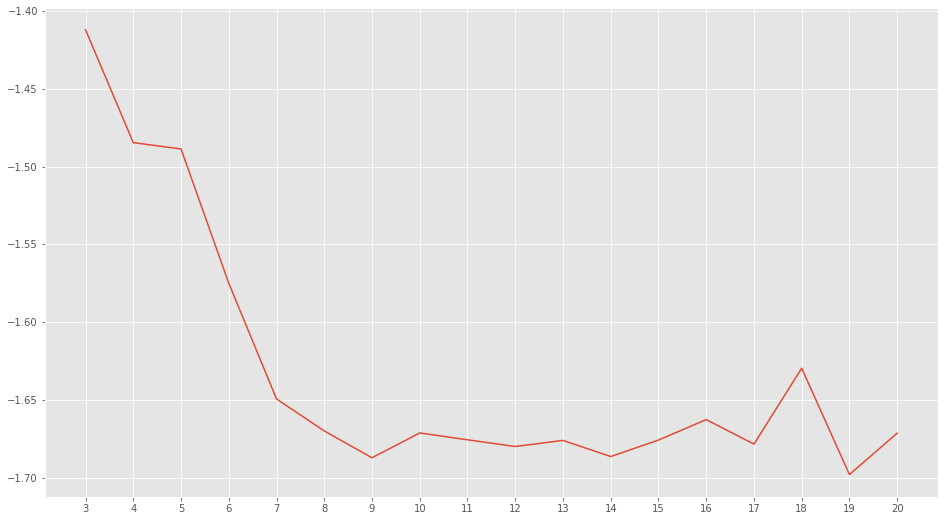

In [6]:
x, y = np.array(n_co_scores).T
plt.plot(x, y)
plt.xticks(x)
plt.grid(True)
plt.show()


From the graph: best **k** is probably at $7$

<!-- , followed by $11$ -->

<!-- > NOTE: choosing $11$ to avoid future mishap, as selecting $3$ yields more documents w/ less than $3$ topic participation -->

---

Due to implementation specifics, `LdaMulticore` doesn't allow using `auto` for &alpha; in constructor. So &alpha; would need to be tuned in a similar fashion.

### Tuning &alpha;


In [7]:
n = 7
a_co_scores = []

for a in np.linspace(0.01, 1, 10):
    lda_model = LdaMulticore(
        bow,
        id2word=id2word,
        num_topics=n,
        random_state=42,
        alpha=a,
        eta="auto",
    )
    co_model = CoherenceModel(
        model=lda_model, texts=corpus, dictionary=id2word, coherence="u_mass"
    )
    a_co_scores.append((a, co_model.get_coherence()))


Selecting the &alpha; w/ best coherence score


In [8]:
a_co_scores = sorted(a_co_scores, key=(lambda tup: tup[1]))
a = a_co_scores[-1][0]


## Saving findings


In [9]:
hyperparameters = np.array([n, a], dtype=float)
np.save(os.path.join(DATA_PATH, "hyperparameters.npy"), hyperparameters)
